In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions
import gensim
import random
from keras.models import Model
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
import keras
import time
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from platform import python_version
from slap import *
import warnings
warnings.filterwarnings("ignore")
po.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None

In [39]:
keras.__version__

'2.2.4'

In [40]:
print(python_version())

3.7.1


## Patient pathway

In [41]:
%%time

#this was made from the cancerdata_EDA.ipynb
df_full_patient_pathways = pd.read_pickle('full_patient_pathways.pkl')

print("shape of patient_pathways ",df_full_patient_pathways.shape)
display(df_full_patient_pathways.head())

shape of patient_pathways  (777581, 119)


TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2 SITE_ICD10_O2_3CHAR  \
15  10001198   10001198        2015-01-16          C443                 C44   
18  10335837   10001198        2015-01-16          C444                 D46   
16  10001198   10001198        2015-01-16          C443                 C44   
17  10001198   10001198        2015-01-16          C443                 C44   
19  10335837   10001198        2015-01-16          C444                 D46   

   MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST M_BEST        ...          \
15           8090                  3    NaN    NaN    NaN        ...           
18           8090                  1    NaN    NaN    NaN        ...           
16           8090                  3    NaN    NaN    NaN        ...           
17           8090                  3    NaN    NaN    NaN        ...           
19           8090                  1    NaN    NaN    NaN        ...           

   ACTUAL_DOSE_PER_ADMINISTRATION OPCS_DELIVERY_CODE ADMINISTRATION_ROUTE  \
15                           55.0                721                    1   
18                           55.0                721                    1   
16                          600.0                NaN                    1   
17                           70.0                NaN                    1   
19                          600.0                NaN                    1   

    ADMINISTRATION_DATE    DRUG_GROUP MERGED_PATIENT_ID  MERGED_TUMOUR_ID_y  \
15           2015-09-02       STEROID          10001198            10002225   
18           2015-09-02       STEROID          10001198            10002225   
16           2015-09-03  BENDAMUSTINE          10001198            10002225   
17           2015-09-03     CISPLATIN          10001198            10002225   
19           2015-09-03  BENDAMUSTINE          10001198            10002225   

   MERGED_REGIMEN_ID_y ADMINISTRATION_ROUTE_DESC DRUG_GROUP_CORRECT  
15            10003952               Intravenous            STEROID  
18            10003952               Intravenous            STEROID  
16            10003952               Intravenous       BENDAMUSTINE  
17            10003952               Intravenous          CISPLATIN  
19            10003952               Intravenous       BENDAMUSTINE  

[5 rows x 119 columns]

CPU times: user 1.03 s, sys: 556 ms, total: 1.59 s
Wall time: 1.63 s


# Assigning events

In [42]:
#only use 3 character icd10 codes for simplicity
df_full_patient_pathways['PRIMARY_DIAGNOSIS'] = df_full_patient_pathways['PRIMARY_DIAGNOSIS'].apply(lambda x: x[0:3])

We want to make a table with the sequence of event per patient, where each row would be one event.

Here `event_type` are the columns we are going to use for the events and `dates` are the dates of those events

In [43]:
%%time

event_types = ['PRIMARY_DIAGNOSIS',
               'BENCHMARK_GROUP',
               'DRUG_GROUP_CORRECT',
               'REGIMEN_MOD_DOSE_REDUCTION',
               'REGIMEN_MOD_TIME_DELAY',
               'REGIMEN_MOD_STOPPED_EARLY',
               'REGIMEN_OUTCOME_SUMMARY']

dates = ['DIAGNOSISDATEBEST',
         'START_DATE_OF_REGIMEN',
         'ADMINISTRATION_DATE',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT',
         'DATE_OF_FINAL_TREATMENT']

df_pathway_events = Sequenceofevents(df_full_patient_pathways, event_types, dates)

df_pathway_events.head(10)

CPU times: user 17.9 s, sys: 865 ms, total: 18.8 s
Wall time: 12.4 s


Assign each unique event a label

In [44]:
df_unique_events = df_pathway_events[['event']].drop_duplicates().reset_index(drop=True)
df_unique_events['event_label'] = df_unique_events.index.astype(str)
df_unique_events.head()

event event_label
0            PRIMARY_DIAGNOSIS C44           0
1     BENCHMARK_GROUP FLUOROURACIL           1
2       DRUG_GROUP_CORRECT STEROID           2
3  DRUG_GROUP_CORRECT BENDAMUSTINE           3
4     DRUG_GROUP_CORRECT CISPLATIN           4

Add the event_label into the sequences_df

In [45]:
df_pathway_events = pd.merge(df_pathway_events, df_unique_events, how='left',on='event')
df_pathway_events.head(10)

PATIENTID                 date                                    event  \
0   10001198  2015-01-16 00:00:00                    PRIMARY_DIAGNOSIS C44   
1   10001198  2015-02-27 00:00:00             BENCHMARK_GROUP FLUOROURACIL   
2   10001198  2015-09-02 00:00:00               DRUG_GROUP_CORRECT STEROID   
3   10001198  2015-09-03 00:00:00          DRUG_GROUP_CORRECT BENDAMUSTINE   
4   10001198  2015-09-03 00:00:00             DRUG_GROUP_CORRECT CISPLATIN   
5   10001976  2014-02-25 00:00:00                    PRIMARY_DIAGNOSIS C44   
6   10001976  2014-10-17 00:00:00                    PRIMARY_DIAGNOSIS C44   
7   10001976  2014-11-16 00:00:00  BENCHMARK_GROUP CISPLATIN + GEMCITABINE   
8   10001976  2015-01-18 00:00:00                 DRUG_GROUP_CORRECT TRIAL   
9   10001976  2015-01-18 00:00:00               DRUG_GROUP_CORRECT STEROID   

           event_type  days PRIMARY_DIAGNOSIS event_label  
0   PRIMARY_DIAGNOSIS     0               C44           0  
1     BENCHMARK_GROUP    42               C44           1  
2  DRUG_GROUP_CORRECT   229               C44           2  
3  DRUG_GROUP_CORRECT   230               C44           3  
4  DRUG_GROUP_CORRECT   230               C44           4  
5   PRIMARY_DIAGNOSIS     0               C44           0  
6   PRIMARY_DIAGNOSIS   234               C44           0  
7     BENCHMARK_GROUP   264               C44           5  
8  DRUG_GROUP_CORRECT   327               C44           6  
9  DRUG_GROUP_CORRECT   327               C44           2

In [46]:
df_unique_events.shape, df_pathway_events.shape

((910, 2), (820065, 7))

There are 915 unique events and 820065 events in total

## word2vec

Convert each unique event into a vector of features.

These features are learned with a neural net using gensim, but we must give as input the sequences of events to find out the features of these events.

In [47]:
#Create a series which has the sequence of events for a given patient
sequences = df_pathway_events.groupby(['PATIENTID'])['event_label'].agg(lambda x: list(x))
sequences.shape

(68687,)

In [48]:
#examples of sequences of events
print(list(sequences)[9])
print(list(sequences)[3])

['35', '5', '10', '7', '3', '10', '36', '25', '37', '10', '10', '38', '39', '40', '2', '41', '42']
['0', '11', '3', '10', '12', '10', '12']


In [49]:
#converts all events to vectors
model = gensim.models.Word2Vec(sentences = list(sequences),
                               size=100, 
                               window=120, 
                               workers =4, 
                               min_count=1,
                               iter = 10)

In [50]:
model['21'] #the vector for event 21

array([-4.63369906e-01,  2.30805516e-01, -6.27566159e-01,  4.97311503e-01,
       -5.99448144e-01, -5.20333827e-01,  5.43495528e-02, -1.97007254e-01,
       -1.10974193e-01,  1.95909113e-01,  3.79632600e-02,  1.90397364e-03,
        6.67168558e-01,  6.98424339e-01, -8.03957403e-01,  6.55904552e-03,
        4.26997244e-01, -1.23131859e+00, -1.61025357e+00, -1.63707763e-01,
       -8.16749632e-01, -8.15971911e-01, -2.88584232e+00,  7.98819065e-02,
        4.53412920e-01,  1.52176499e-01,  5.50565898e-01,  5.13539553e-01,
        7.28124976e-01,  1.07326400e+00,  4.86495823e-01,  9.37597811e-01,
        3.63084227e-02, -4.45927024e-01,  1.42317802e-01, -9.51824129e-01,
       -8.79129052e-01, -7.10991681e-01, -5.96585989e-01, -2.35038489e-01,
       -9.63389575e-01,  1.72383770e-01,  6.12153947e-01, -5.78389525e-01,
        7.46313035e-01,  1.05080992e-01,  6.55945957e-01,  1.23053186e-01,
        2.05422089e-01,  1.06707370e+00, -6.94196522e-01,  6.96165860e-01,
       -1.14030086e-01, -

In [ ]:
len(model.wv.vocab)

910

## Dimension reduction

Use umap to reduce the size of the vectors and project onto an optimal 2D dimension where clusters of individual events may be identified

In [ ]:
X = model[model.wv.vocab]
#pca = PCA(n_components=2)
#tsne = TSNE(n_components=2)
um = umap.UMAP(n_components=2)
result = um.fit_transform(X)

* PCA finds the best projection of the data into a 2D plane such that the points are maximally separated.
* TSNE tries to preserve the same proportions of distances between points, in the 100D spae and the 3D space.
* not sure about umap


Get 2D co-ordinates of each event:

In [ ]:
df_event_vector = pd.DataFrame({'event_label':list(model.wv.vocab.keys()),
                                'x':result[:,0],
                                'y':result[:,1]})
df_label_type = df_pathway_events[['event_type','event_label']].drop_duplicates()
df_event_vector = pd.merge(df_event_vector,df_label_type,on='event_label', how='left')

print(df_event_vector.shape)
df_event_vector.head()

(910, 4)


event_label         x         y          event_type
0           0  4.030676  0.730472   PRIMARY_DIAGNOSIS
1           1  0.925166  8.432444     BENCHMARK_GROUP
2           2  2.284403  3.627123  DRUG_GROUP_CORRECT
3           3  4.049843 -0.226089  DRUG_GROUP_CORRECT
4           4 -0.453973  4.046115  DRUG_GROUP_CORRECT

In [ ]:
#plot the events, colour coded by event_type
plotevents(df_event_vector, event_types)

Each point here corresponds to a unique event in the word2vec space, it seems like the events have clustered into different regions, most likely those different regions correspond to different cancers as you would expect each cancer to have distinct(although not entirely) events from other cancers

### patient pathway visualization

This section adds up all the word2vec vectors for a given individual patient, this is one way to visualize a pathway and to see if there are (di)similar pathways

In [ ]:
#get the list of days corresponding to each event in a sequence of events
sequence_days = df_pathway_events.groupby(['PATIENTID'])['days'].agg(lambda x: list(x))
df_sequences = pd.DataFrame({'sequence':sequences,'sequence_days':sequence_days})

#get cancer diagnosis of each patient for colour coding
df_cancers = df_full_patient_pathways[['PATIENTID','PRIMARY_DIAGNOSIS']].drop_duplicates()
df_sequences = pd.merge(df_sequences, df_cancers, how='left', on='PATIENTID')

df_sequences['sequence_length'] = df_sequences['sequence'].apply(len)

df_sequences.head()

PATIENTID                                          sequence  \
0   10001198                                   [0, 1, 2, 3, 4]   
1   10001976                             [0, 0, 5, 6, 2, 7, 8]   
2   10002361                                     [0, 1, 9, 10]   
3   10002568                        [0, 11, 3, 10, 12, 10, 12]   
4   10002929  [13, 10, 14, 0, 15, 4, 16, 2, 17, 18, 0, 19, 10]   

                                       sequence_days PRIMARY_DIAGNOSIS  \
0                             [0, 42, 229, 230, 230]               C44   
1                  [0, 234, 264, 327, 327, 327, 434]               C44   
2                                 [0, 427, 427, 427]               C44   
3                  [0, 934, 962, 962, 963, 963, 990]               C44   
4  [0, 0, 7, 155, 184, 184, 184, 184, 184, 213, 2...               C44   

   sequence_length  
0                5  
1                7  
2                4  
3                7  
4               13

In [ ]:
#create a map that gets you from the event to its 2D PCA vector
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X)
map2D = {k:vector for k,vector in zip(model.wv.vocab.keys(),pca_vectors)}

Now add up the vectors of events in a sequence to get the pathway and plot it

In [ ]:
plotpathways(df_sequences, topN=5, map2D=map2D)

The pathways look like they've clustered well according to the type of cancer, meaning similar cancers have similar drugs/regimens, this isn't really usefull information, so it's better to try and use a clustering algorithm on a specific cancer

### Clustering of single cancer pathways with TFIDF

Start of by looking at c50 (breast)

In [ ]:
single_cancer = 'C50' #3char
df_single_cancer = df_sequences[df_sequences['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = df_single_cancer['sequence']
df_single_cancer.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  
41               11  
59                4  
64                5  
75                8  
77               17

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) converts a collection of raw documents to a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features.

In the patient pathway case, given a sequence, the TF-IDF of an event in that sequence would be a number between 0 to 1.
This number will:
* increase if that event is frequent in that sequence
* decrease if that event is frequent in all sequences

Each sequence will have a vector where the elements are the TF-IDF values of the events in that sequence. We would like to cluster these vectors to represent the clustering of the pathways.

The downside to using this is that this vector does not have information on the order of events.

In [ ]:
#preprocess sequences to input into TfidfVectorizer
print("len(single_cancer_sequences):", len(single_cancer_sequences))
documents = [' '.join(s) for s in single_cancer_sequences]

#Make the sequences into vectors
vectorizer = TfidfVectorizer(max_df=1000000)
tfidf_vectors = vectorizer.fit_transform(documents)
print("tfidf_vectors.shape: ",tfidf_vectors.shape)

len(single_cancer_sequences): 18661
tfidf_vectors.shape:  (18661, 305)


In [ ]:
#cluster these vectors
n_clusters = 6
kmeans = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1).fit(X=tfidf_vectors)

#add cluster labels
lab = kmeans.labels_
df_single_cancer['cluster'] = lab

#use pca on the TFIDF vectors to visualize the sequences and how they've clustered
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(tfidf_vectors.toarray())

df_single_cancer['x'] = pca_vectors[:,0]
df_single_cancer['y'] = pca_vectors[:,1]
df_single_cancer.head()

PATIENTID                                           sequence  \
41   10073021         [83, 84, 22, 85, 22, 8, 2, 47, 86, 10, 29]   
59   10120084                                    [62, 9, 10, 83]   
64   10137351                                [83, 21, 10, 2, 10]   
75   10153352                   [83, 124, 9, 10, 10, 47, 10, 30]   
77   10163033  [83, 120, 7, 124, 7, 10, 63, 17, 25, 2, 40, 12...   

                                        sequence_days PRIMARY_DIAGNOSIS  \
41  [0, 97, 97, 156, 156, 156, 163, 163, 414, 414,...               C50   
59                                     [0, 0, 0, 574]               C50   
64                            [0, 559, 559, 566, 566]               C50   
75             [0, 660, 681, 681, 702, 716, 716, 723]               C50   
77  [0, 415, 415, 417, 417, 438, 439, 439, 459, 54...               C50   

    sequence_length  cluster         x         y  
41               11        1  0.069390  0.019828  
59                4        1  0.060652  0.010328  
64                5        1 -0.068759 -0.022527  
75                8        1  0.020774 -0.007963  
77               17        1  0.050960  0.005686

In [ ]:
sequenceclusterplot(df_single_cancer, feature_space="TFIDF")

An individual point on this plot represents the pathway of an individual patient. They are colour coded by the cluster they belong to.

The clustering doesn't seem to have done very well here

histogram of clusters:

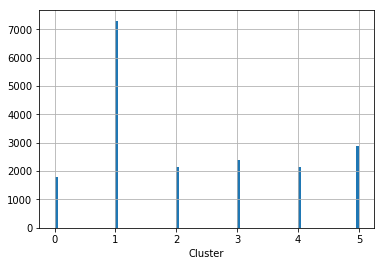

In [ ]:
pd.Series(lab).hist(bins = 100)
plt.xlabel("Cluster")
plt.show()

The top 5 regimens and drugs in each cluster:

Given a cluster, what are the top drugs/regimens/outcome in that cluster, and how many days did it take until that event happened?

In [ ]:
clusterinfo(df_single_cancer,df_pathway_events,single_cancer,cluster=1,top=5)

Cluster 1 

mean number of events:  14.90 

top 5 drugs, regimens and outcome, showing how many days from the first event that they were administered:


DRUG_GROUP_CORRECT  frequency   mean days
0          NOT CHEMO      13912  331.824612
1   CYCLOPHOSPHAMIDE      11438  325.869208
2         EPIRUBICIN      10529  320.609175
3        TRASTUZUMAB       7963  287.584830
4       FLUOROURACIL       7681  325.421690

BENCHMARK_GROUP  frequency   mean days
0                            EC       2064  244.633721
1                    PACLITAXEL       1605  284.984424
2                     NOT CHEMO        913  246.893757
3  CYCLOPHOSPHAMIDE + DOCETAXEL        833  229.795918
4                     DENOSUMAB        601  349.301165

REGIMEN_OUTCOME_SUMMARY  frequency   mean days
0                       0        798  327.122807
1                       3        135  291.644444
2                       2         95  433.200000
3                       5         33  366.666667
4                       1         24  382.000000

The TFIDF features do not include information on the order of the events that happened. The only information is the frequency of each event in a sequence and the frequency of events in all sequences.

With an LSTM it can learn the ordering of events and possibly other information which it might discover.

### Using LSTM as an autoencoder for clustering

The LSTM sequence model used is shown in the diagram below. Using this we can extract the encoding(a vector of length 100 say) of any sequence. These encodings will have information on the order of the sequence and it's contents(events).

The LSTM autoencoder is trained to output the same sequence that it was input. This is so that given the information from the encoding, it should be able to reconstruct the same sequence from that encoding.

<img src="docs/LSTM.png" alt="LSTM" width="800"/>

For the inputs we will use the word2vec representation of events to improve computation speed:

In [ ]:
single_cancer = 'C50' #3char
df_single_cancer = df_sequences[df_sequences['PRIMARY_DIAGNOSIS'] == single_cancer]
single_cancer_sequences = df_single_cancer['sequence']
df_single_cancer.head()

nfeatures = 50
model50D = gensim.models.Word2Vec(sentences = list(df_single_cancer['sequence']), 
                                  size=nfeatures, 
                                  window=120, 
                                  workers =4, 
                                  min_count=1,
                                  iter = 5)

sequence_vectors = single_cancer_sequences.apply(lambda x: np.array([list(model50D[event]) for event in x]))

sequence_vectors = list(sequence_vectors)

#in the word2vec representation of an event
#attach the number of days on the the end of that vector

#rescale days to have roughly the same magnitude as
#the elements in word2vec vectors
sequence_days = [np.array(days) for days in df_single_cancer['sequence_days']]
max_days = np.hstack(sequence_days).max()
max_vector_value = np.hstack([np.hstack(s_v) for s_v in sequence_vectors]).max()
sequence_days = [days*(max_vector_value/max_days) for days in sequence_days]

sequence_vectors = [np.concatenate((vectors,days.reshape(days.shape[0],-1)),axis=1) 
                    for vectors,days in zip(sequence_vectors,sequence_days)]
sequence_vectors[0].shape

(11, 51)

`sequence_vectors` is a list of arrays, each array has shape (number of events, features of events = 51)

Each element in `sequence_vectors` is a sequence that is an input to the LSTM model, and we are training the model to output the same input.

The model is kept simple and is only 3 layers. We do not want to make it as robust as possible because if it is very accurate then it could be overfitted to the simulacrum which is a simulated dataset, in order for this model to generalize to the real data, the model has to be kept simple.

Some variables to set for the model:

In [ ]:
nsequences = len(sequence_vectors)

#this is needed in order for the model to
#work with sequences of differing lengths
def train_generator():
    """yields sequences from sequence_vectors at random
    which is then used to train the model"""
    while True:
        s = sequence_vectors[random.randrange(nsequences)]
        s = s.reshape((1, s.shape[0], s.shape[1]))
        yield s,s
        
train_gen = train_generator()
            
input_dim = nfeatures+1
encoding_dim = 100

Initialize the structure of the LSTM sequence model:

In [ ]:
inputs = Input(shape=(None, input_dim))

middle_outputs, encoding, cell_state = LSTM(encoding_dim, return_sequences=True, return_state=True)(inputs)

outputs = LSTM(input_dim, return_sequences=True)(middle_outputs)

autoencoder = Model(inputs=inputs, outputs=outputs)

Train the model (~1 minutes):

In [ ]:
a = time.time()

autoencoder.compile(optimizer='adam', loss='mse')

batch_size = 500
autoencoder.fit_generator(train_gen, 
                          steps_per_epoch=round(nsequences/batch_size), 
                          epochs=40,
                          verbose=1)

autoencoder.save('patient_pathway_autoencoder1.h5')

print("fit time (s): ", time.time() - a)

Epoch 1/40
37/37 [==============================] - 2s 66ms/step - loss: 0.1201
Epoch 2/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0918
Epoch 3/40
37/37 [==============================] - 1s 19ms/step - loss: 0.0795
Epoch 4/40
37/37 [==============================] - 1s 21ms/step - loss: 0.0585
Epoch 5/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0494
Epoch 6/40
37/37 [==============================] - 1s 18ms/step - loss: 0.0324
Epoch 7/40
37/37 [==============================] - 1s 19ms/step - loss: 0.0276
Epoch 8/40
37/37 [==============================] - 1s 23ms/step - loss: 0.0264
Epoch 9/40
37/37 [==============================] - 1s 19ms/step - loss: 0.0239
Epoch 10/40
37/37 [==============================] - 1s 21ms/step - loss: 0.0210
Epoch 11/40
37/37 [==============================] - 1s 22ms/step - loss: 0.0204
Epoch 12/40
37/37 [==============================] - 1s 16ms/step - loss: 0.0178
Epoch 13/40
37/37 [==================

In [ ]:
autoencoder = load_model('patient_pathway_autoencoder1.h5')

#make a model with the output as the encoding
encoder_model = Model(inputs = autoencoder.inputs, outputs = autoencoder.layers[1].output)

Get the encodings of each sequence:

In [ ]:
%%time
#reshape into correct input shape
input_sequences = [np.expand_dims(s, axis=0) for s in list(sequence_vectors)]

sequence_features = np.zeros((nsequences,100))
for i,s in enumerate(input_sequences):
    
    #get the encoding(hidden layer)
    sequence_features[i,:] = encoder_model.predict(s)[1]

CPU times: user 1min 6s, sys: 27.3 s, total: 1min 34s
Wall time: 29.5 s


Cluster the encodings

In [ ]:
#clustering the encodings of all sequences
#20 clusters chosen as they are a lot more distinct,see plot below
n_clusters=20
kmeans = KMeans(n_clusters, init='k-means++', max_iter=100, n_init=1).fit(X=sequence_features)
lab = kmeans.labels_
print("lab.shape: ",lab.shape)

df_single_cancer['cluster'] = lab
df_single_cancer.to_pickle("patiend_id_cluster.pkl")

In [ ]:
#map the encodings into 2D space
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(sequence_features)

df_single_cancer['x'] = pca_vectors[:,0]
df_single_cancer['y'] = pca_vectors[:,1]
df_single_cancer.head()

Plot the sequences in the LSTM feature space

In [ ]:
sequenceclusterplot(df_single_cancer, feature_space="LSTM")

histogram of clusters:

In [ ]:
pd.Series(lab).hist(bins = 100)
plt.xlabel("Cluster")
plt.show()

In [ ]:
clusterinfo(df_single_cancer,df_pathway_events,single_cancer,cluster=1,top=5)